## Introduction

**Objective:**

The [California housing dataset](https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset) provides median house prices for California districts (block groups) from a US census.

Our goal here will be to build data preprocessing pipeline and a fine-tuned ML model to predict median house prices of a block group using the following attributes:
 - MedInc : median income in block group
 - HouseAge : median house age in block group
 - AveRooms : average number of rooms per household
 - AveBedrms : average number of bedrooms per household
 - Population : block group population
 - AveOccup : average number of household members
 - Latitude : block group latitude
 - Longitude : block group longitude.

Let's load essential packages and inform ourselves of their version in use:

In [1]:
print('Python Version : 3.9.18')

# for data manipulation
import pandas as pd
print('Pandas Version : ', pd.__version__)
import numpy as np
print('NumPy Version : ', np.__version__)

# for data visualization
import matplotlib.pyplot as plt 
import matplotlib as mpl
print('Matplotlib Version : ', mpl.__version__)

# for machine learning
import sklearn as skl
print('SciKit-Learn Version : ', skl.__version__)

Python Version : 3.9.18
Pandas Version :  2.0.3
NumPy Version :  1.24.3
Matplotlib Version :  3.7.2
SciKit-Learn Version :  1.3.0


## Obtaining Dataset

We load the data using SciKit-Learn datasets and print its description.

In [3]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()
print(housing.data.shape, housing.target.shape)
print(housing.feature_names, housing.target_names)

(20640, 8) (20640,)
['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude'] ['MedHouseVal']


In [4]:
print(housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

**Task**: To check out-of-sample model performance, we would need to hold out some data for predicting prices of housing once we have the final model.

**Strategy:** We will split the dataset into training and test sets and put aside the test data to not be seen at all until we want to test our final model on it.

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(housing.data, housing.target, test_size=0.25, random_state=42)

**Task**: The data may need preprocessing before a regression model can be trained on it.

**Strategy**: We will create a Pandas DataFrame from X_train so we can manipulate and visualize it more conveniently.

In [6]:
df = pd.DataFrame(X_train, columns=housing.feature_names)
df['MedHouseVal'] = y_train
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,4.2143,37.0,5.288235,0.973529,860.0,2.529412,33.81,-118.12,2.285
1,5.3468,42.0,6.364322,1.087940,957.0,2.404523,37.16,-121.98,2.799
2,3.9191,36.0,6.110063,1.059748,711.0,2.235849,38.45,-122.69,1.830
3,6.3703,32.0,6.000000,0.990196,1159.0,2.272549,34.16,-118.41,4.658
4,2.3684,17.0,4.795858,1.035503,706.0,2.088757,38.57,-121.33,1.500


## Data Preprocessing

Let's visualize histogram of the dataframe:

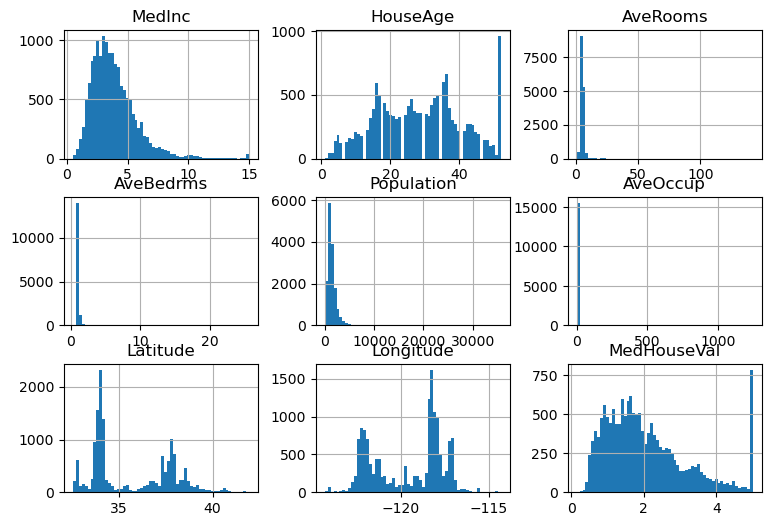

In [7]:
df.hist(bins=60, figsize=(9,6))
plt.show()

**Observation**: The Ave* and Population distributions are highly skewed.

**Task**: Regression models don't work well on highly skewed data, so we need to transform these.

**Strategy**: Doing power-transformation on `['AveRooms', 'AveBedrms', 'AveOccup', 'Population']` may help improve their correlation. We'll also do standardization on rest of the attributes.

In [8]:
df_a = df[['AveRooms', 'AveBedrms', 'AveOccup', 'Population']]
df_b = df[['MedInc', 'HouseAge']]
df_c = df[['Latitude', 'Longitude', 'MedHouseVal']]

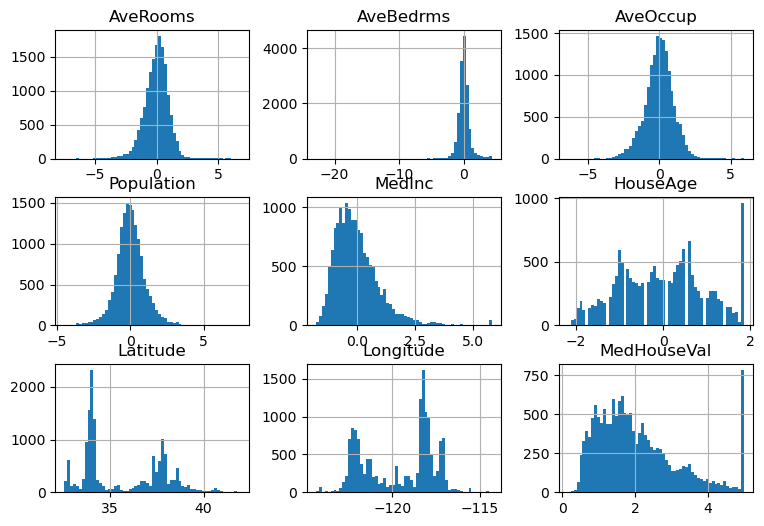

In [9]:
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
import numpy as np
pt = PowerTransformer(method='yeo-johnson')
ss = StandardScaler()
df2 = pd.DataFrame(
    np.concatenate((pt.fit_transform(df_a),
                    ss.fit_transform(df_b),
                    df_c),
                    axis=1),
    columns=['AveRooms', 'AveBedrms', 'AveOccup', 'Population',
             'MedInc', 'HouseAge', 'Latitude', 'Longitude',
             'MedHouseVal'])

df2.hist(bins=60, figsize=(9,6))
plt.show()

**Observation**: With above, the first 6 attributes ('AveRooms', 'AveBedrms', 'AveOccup', 'Population', 'MedInc', 'HouseAge') have been transformed for use as features in the regression model. 

**Task**: Latitude and Longitude attributes need processing to engineer feature(s) that can serve as predictors in regression model.

**Strategy**: We will plot the median house values on coordinates map, to see if prices tend to be high at certain locations.

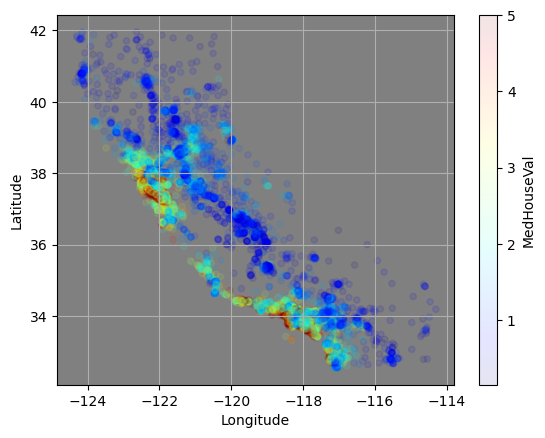

In [10]:
ax = df2.plot(kind="scatter", x="Longitude", y="Latitude", grid=True, alpha=0.1, c="MedHouseVal", colormap='jet')
ax.set_facecolor('grey')
plt.show()

**Observation**: Prices do tend to be high close to two locations near the coast.

**Task** : We require a way to find the cluster centers and transform the coordinate columns (Latitude and Longitude) into features that describe proximity of the block group to these clusters. This may help with the prediction of higher prices near the cluster centers.

**Strategy**: We can do MedHouseVal-weighted k-means clustering (with k=2) to locate these cluster centers and then use radial basis function to transform the coordinates into two features that assess the geographical proximity of a block group with these cluster centres.

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel

# Let's create a cluster proximity transformer for X (Longitude and Latitude columns) which:
#  - estimates/finds clusters in X using KMeans in the fit method, and
#  - transforms X into proximity measures using rbf_kernel in the transform method
class ClusterProximity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=2, gamma=0.5, random_state=42):
        # set hyperparameters of KMeans and rbf_kernel:
        self.n_clusters = n_clusters # number of cluster centers to be estimated
        self.random_state = random_state # reproducible pseudo-randomness
        self.gamma = gamma # varies width of the Gaussian RBF
        
    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state, n_init=10)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)


In [12]:
cluster_proximity = ClusterProximity()
proximities = cluster_proximity.fit_transform(df2[["Latitude", "Longitude"]], sample_weight=df2["MedHouseVal"]).round(4)

**Task**: Visually verify that the algorithm located the cluster centers.

**Strategy**: We will extract the cluster centers via `cluster_proximity.kmeans_.cluster_centers_` and plot the instances (i.e. the block groups) again but this time color them by `proximities` data. We'll plot separately for each cluster.

In [13]:
centers = pd.DataFrame(cluster_proximity.kmeans_.cluster_centers_, columns=["Latitude", "Longitude"])
df2['Proximity_C0'] = proximities[:, 0]
df2['Proximity_C1'] = proximities[:, 1]

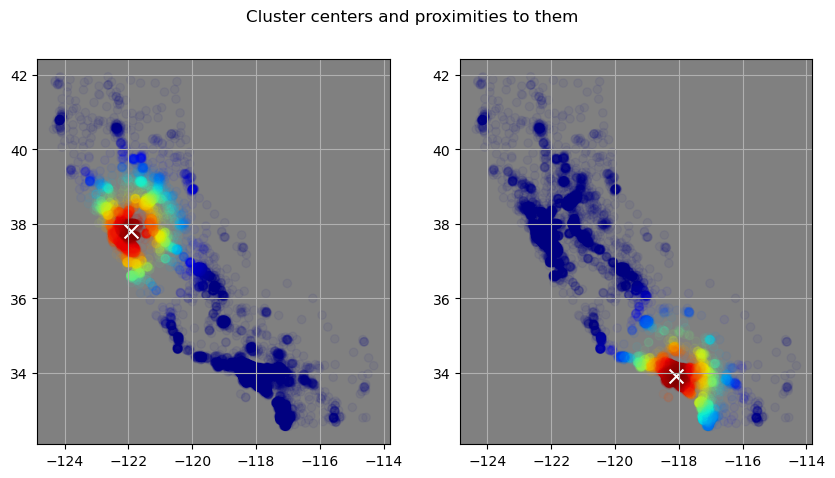

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Cluster centers and proximities to them')
ax1.scatter(df2["Longitude"], df2["Latitude"], c=df2["Proximity_C0"], cmap='jet', alpha=0.05)
ax1.scatter(centers["Longitude"][0], centers["Latitude"][0], marker='x', c='w', s=100)
ax1.grid()
ax1.set_facecolor('grey')
ax2.scatter(df2["Longitude"], df2["Latitude"], c=df2["Proximity_C1"], cmap='jet', alpha=0.05)
ax2.scatter(centers["Longitude"][1], centers["Latitude"][1], marker='x', c='w', s=100)
ax2.grid()
ax2.set_facecolor('grey')

plt.show()

**Observation**: The proximity columns work as expected.

**Task**: We can drop the Latitude and Longitude columns and move to model selection.

In [15]:
df2.drop(columns=['Latitude', 'Longitude'], inplace=True)

## Model Selection

**Task**: Train a linear model and check its performance to get an idea of error with a simple linear model.

**Strategy**: Let's train a linear regression model. Since we need to compare performance of different models for model selection, I would use k-fold cross validation during the training. This way, we would have an out-of-sample error measure of various models.

In [16]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()

In [17]:
from sklearn.model_selection import cross_val_score

lin_reg_rmse = -cross_val_score(lin_reg, df2.drop(columns=['MedHouseVal']), df2['MedHouseVal'], scoring="neg_root_mean_squared_error", cv=5)
lin_reg_rmse.mean()

0.6983846598616856

In [18]:
df2['MedHouseVal'].describe()

count    15480.000000
mean         2.070349
std          1.155163
min          0.149990
25%          1.196750
50%          1.796000
75%          2.647000
max          5.000010
Name: MedHouseVal, dtype: float64

**Observation**: Most block groups range between USD 120,000 and USD 265,000 (interquartile range), so a typical prediction error of USD 69,838 doesn't sound great.

**Task**: Let's look at the learning curves to check if the model is underfitting the data.

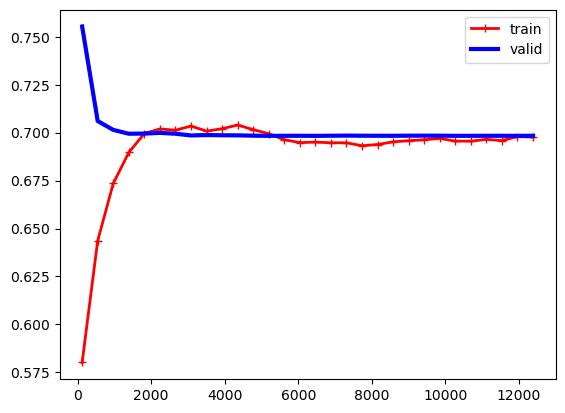

In [19]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(
    lin_reg, 
    df2.drop(columns=['MedHouseVal']), df2['MedHouseVal'],
    train_sizes=np.linspace(0.01, 1.0, 30), cv=5,
    scoring="neg_root_mean_squared_error")

train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")
plt.legend()
plt.show()

**Observation**: Indeed, the model is underfitting (since after about 25% data, adding more data to training doesn't help, and also since the training and validation error overlap upon saturation).

**Task**: Let's train decision tree regressor.

In [20]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor(random_state=42)

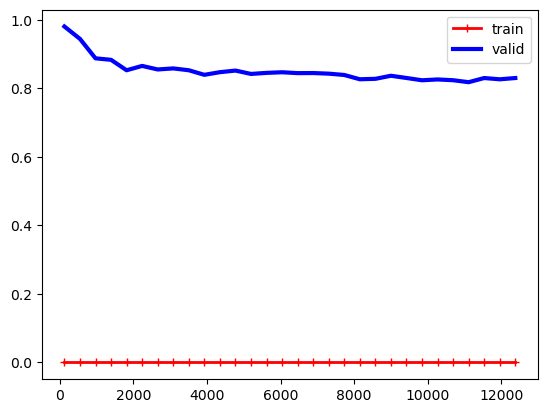

In [21]:
train_sizes, train_scores, valid_scores = learning_curve(
    tree_reg, 
    df2.drop(columns=['MedHouseVal']), df2['MedHouseVal'],
    train_sizes=np.linspace(0.01, 1.0, 30), cv=5,
    scoring="neg_root_mean_squared_error")

train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")
plt.legend()
plt.show()

**Observation**: This model is overfitting (since there is gap in training and validation error upon saturation).

**Task**: Let's train random forest regression.

In [22]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(random_state=42)

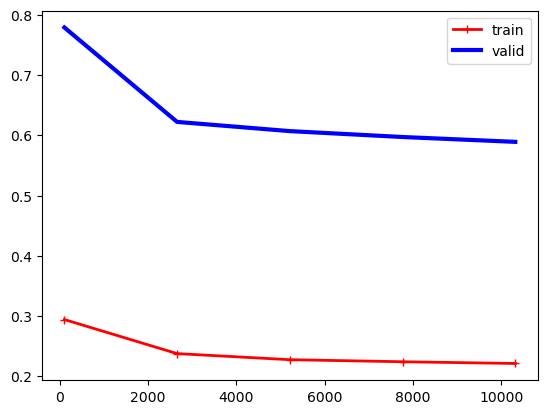

In [23]:
train_sizes, train_scores, valid_scores = learning_curve(
    forest_reg, 
    df2.drop(columns=['MedHouseVal']), df2['MedHouseVal'],
    train_sizes=np.linspace(0.01, 1.0, 5), cv=3,
    scoring="neg_root_mean_squared_error")

train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")
plt.legend()
plt.show()

**Observation**: This model performs well: the error decreases with training set size in both cases. It neither underfits nor overfits.

## Tuning Model

**Task**: Create a fine-tuned Random Forest Regressor model.

In [24]:
from sklearn.model_selection import GridSearchCV

params = {'n_estimators': [15, 30, 60, 120, 240]}
search = GridSearchCV(forest_reg, params, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
search.fit(df2.drop(columns=['MedHouseVal']), df2['MedHouseVal'])
print(search.best_params_)

{'n_estimators': 240}


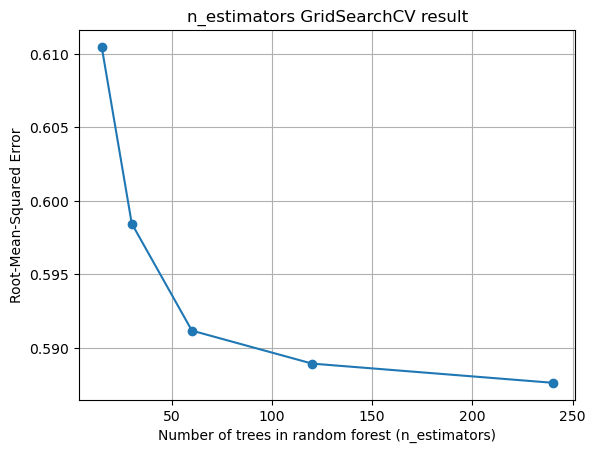

In [25]:
fig, ax = plt.subplots()
ax.plot([15, 30, 60, 120, 240], -search.cv_results_['mean_test_score'], 'o-')
ax.set(xlabel='Number of trees in random forest (n_estimators)', ylabel='Root-Mean-Squared Error',
       title='n_estimators GridSearchCV result')
ax.grid()
plt.show()

In [26]:
forest_reg = RandomForestRegressor(random_state=42, n_estimators=240)
params = {'min_samples_split': [2, 3, 4, 5, 6]}
search = GridSearchCV(forest_reg, params, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
search.fit(df2.drop(columns=['MedHouseVal']), df2['MedHouseVal'])
print(search.best_params_)

{'min_samples_split': 3}


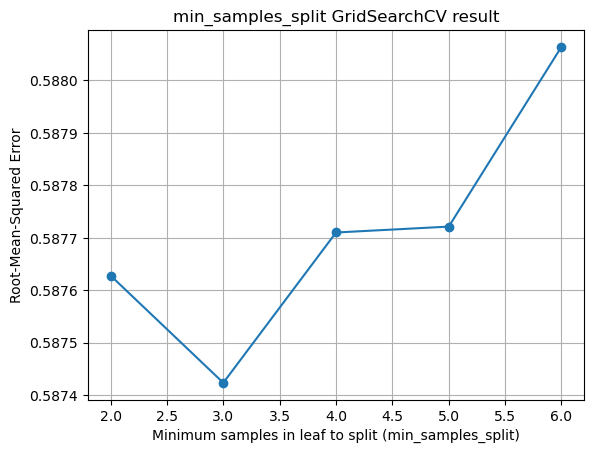

In [27]:
fig, ax = plt.subplots()
ax.plot([2, 3, 4, 5, 6], -search.cv_results_['mean_test_score'], 'o-')
ax.set(xlabel='Minimum samples in leaf to split (min_samples_split)', ylabel='Root-Mean-Squared Error',
       title='min_samples_split GridSearchCV result')
ax.grid()
plt.show()

In [28]:
forest_reg = RandomForestRegressor(random_state=42, n_estimators=240, min_samples_split=3)
params = {'max_features': ['sqrt', 'log2', 1.0]}
search = GridSearchCV(forest_reg, params, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
search.fit(df2.drop(columns=['MedHouseVal']), df2['MedHouseVal'])
print(search.best_params_)

{'max_features': 'log2'}


In [29]:
-search.cv_results_['mean_test_score']

array([0.57026708, 0.56749859, 0.58742336])

In [4]:
round(np.mean([0.57026708, 0.56749859, 0.58742336])*100000)

57506

**Conclusion**:

Finally, we have a fine-tuned Random Forest Regressor model with hyperparameters as follows:
- n_estimators = 240
- min_samples_split = 3
- max_features = 'log2'

The RMSE (root mean squared error) with this ensemble learning model is **USD 57,506**.

## Further reading

An even lower RMSE of USD 40,782 [can be achieved with XGBoost (extreme gradient boosting)](https://www.kaggle.com/code/camnugent/geospatial-feature-engineering-and-visualization?scriptVersionId=2231442&cellId=38).